In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    multilabel_confusion_matrix,
    f1_score,
    hamming_loss,
    jaccard_score,
)
from sklearn.model_selection import KFold

### Data & Visualisation

Multi-label classification

4096 instances

12 genese

In [2]:
# We load from pre-processed data

full_data = np.load("/data/public/boolean_networks/budding/budding_raw_data.npy")

### Common code

In [3]:
# Config
NUM_FOLD = 10
RANDOM_STATE = 73

In [4]:
def get_fold_print_string(fold_result: list[float]):
    mean = np.mean(fold_result)
    ste = np.std(fold_result) / np.sqrt(NUM_FOLD)
    return f"{mean:.3f} ± {ste:.3f}"

In [5]:
def binary_classification(
    model,
    model_name: str,
    n_splits: int = NUM_FOLD,
    random_state: int = RANDOM_STATE,
    print_cm: bool = False,
):
    print(f"Model {model_name} with {n_splits}-fold cross-validation\n")

    # K-Fold
    kf = KFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state,
    )

    fold_hamming_loss = []
    fold_micro_f1 = []
    fold_micro_jaccard = []

    for i, (train_index, test_index) in enumerate(kf.split(np.arange(len(full_data)))):
        train_X = full_data[train_index, 0]
        train_y = full_data[train_index, 1]
        test_X = full_data[test_index, 0]
        test_y = full_data[test_index, 1]

        model.fit(train_X, train_y)

        y_pred = model.predict(test_X)

        hamming_loss_score = hamming_loss(test_y, y_pred)
        micro_f1 = f1_score(test_y, y_pred, average="micro")
        micro_jaccard = jaccard_score(test_y, y_pred, average="micro")

        fold_hamming_loss.append(hamming_loss_score)
        fold_micro_f1.append(micro_f1)
        fold_micro_jaccard.append(micro_jaccard)

        print(
            f"Fold {i}: F1={micro_f1:.4f}, Jaccard={micro_jaccard:.4f}, Hamming={hamming_loss_score:.4f}"
        )

        if print_cm:
            cm = multilabel_confusion_matrix(test_y, y_pred)
            print(cm)


    print("\nCross-Validation Results:")
    print(f"Mean Hamming Loss: {get_fold_print_string(fold_hamming_loss)}")
    print(f"Mean Micro F1: {get_fold_print_string(fold_micro_f1)}")
    print(f"Mean Micro Jaccard: {get_fold_print_string(fold_micro_jaccard)}")


## Random forest

In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=72)
binary_classification(model, "Random Forest")

Model Random Forest with 10-fold cross-validation

Fold 0: F1=0.9953, Jaccard=0.9906, Hamming=0.0041
Fold 1: F1=0.9968, Jaccard=0.9936, Hamming=0.0028
Fold 2: F1=0.9966, Jaccard=0.9933, Hamming=0.0028
Fold 3: F1=0.9961, Jaccard=0.9921, Hamming=0.0035
Fold 4: F1=0.9960, Jaccard=0.9921, Hamming=0.0035
Fold 5: F1=0.9959, Jaccard=0.9918, Hamming=0.0037
Fold 6: F1=0.9964, Jaccard=0.9929, Hamming=0.0031
Fold 7: F1=0.9972, Jaccard=0.9944, Hamming=0.0024
Fold 8: F1=0.9958, Jaccard=0.9916, Hamming=0.0035
Fold 9: F1=0.9959, Jaccard=0.9919, Hamming=0.0035

Cross-Validation Results:
Mean Hamming Loss: 0.003 ± 0.000
Mean Micro F1: 0.996 ± 0.000
Mean Micro Jaccard: 0.992 ± 0.000


## Decision tree

In [7]:
# Function to calculate the average depth of the decision tree
def average_tree_depth(tree):
    def _recursive_depth(node, current_depth, depths):
        if (
            tree.children_left[node] == tree.children_right[node]
        ):  # It's a leaf node
            depths.append(current_depth)
            return
        _recursive_depth(tree.children_left[node], current_depth + 1, depths)
        _recursive_depth(tree.children_right[node], current_depth + 1, depths)

    depths = []
    _recursive_depth(0, 0, depths)  # Start from the root node (index 0)
    return sum(depths) / len(depths)


# Function to count the number of branches (internal nodes)
def count_branches(tree):
    n_nodes = tree.node_count  # Total number of nodes in the tree
    n_leaves = tree.n_leaves  # Total number of leaf nodes
    n_branches = n_nodes - n_leaves  # Number of internal nodes (branches)
    return n_branches

In [8]:
model = DecisionTreeClassifier(random_state=74, class_weight="balanced")
print(f"Decision tree with {NUM_FOLD}-fold cross-validation\n")
kf = KFold(n_splits=NUM_FOLD, shuffle=True, random_state=RANDOM_STATE)

fold_hamming_loss = []
fold_micro_f1 = []
fold_micro_jaccard = []
tree_stats: list[dict[str, float]] = []

for i, (train_index, test_index) in enumerate(kf.split(np.arange(len(full_data)))):
    train_X = full_data[train_index, 0]
    train_y = full_data[train_index, 1]
    test_X = full_data[test_index, 0]
    test_y = full_data[test_index, 1]
    model.fit(train_X, train_y)

    y_pred = model.predict(test_X)

    hamming_loss_score = hamming_loss(test_y, y_pred)
    micro_f1 = f1_score(test_y, y_pred, average="micro")
    micro_jaccard = jaccard_score(test_y, y_pred, average="micro")

    max_depth = model.get_depth()
    avg_depth = average_tree_depth(model.tree_)
    n_branches = count_branches(model.tree_)

    fold_hamming_loss.append(hamming_loss_score)
    fold_micro_f1.append(micro_f1)
    fold_micro_jaccard.append(micro_jaccard)

    tree_stats.append(
        {
            "max_depth": max_depth,
            "avg_depth": avg_depth,
            "n_branches": n_branches,
        }
    )

    print(
        f"Fold {i}: F1={micro_f1:.4f}, Jaccard={micro_jaccard:.4f}, Hamming={hamming_loss_score:.4f}"
    )


print("\nCross-Validation Results:")
print(f"Mean Hamming Loss: {get_fold_print_string(fold_hamming_loss)}")
print(f"Mean Micro F1: {get_fold_print_string(fold_micro_f1)}")
print(f"Mean Micro Jaccard: {get_fold_print_string(fold_micro_jaccard)}")

print("\nTree Stats:")
print(
    f"Avg Max Depth: {get_fold_print_string([x['max_depth'] for x in tree_stats])}"
)
print(
    f"Avg Avg Depth: {get_fold_print_string([x['avg_depth'] for x in tree_stats])}"
)
print(
    f"Avg Branches: {get_fold_print_string([x['n_branches'] for x in tree_stats])}"
)

Decision tree with 10-fold cross-validation

Fold 0: F1=0.9710, Jaccard=0.9436, Hamming=0.0250
Fold 1: F1=0.9768, Jaccard=0.9547, Hamming=0.0205
Fold 2: F1=0.9696, Jaccard=0.9410, Hamming=0.0256
Fold 3: F1=0.9743, Jaccard=0.9499, Hamming=0.0226
Fold 4: F1=0.9706, Jaccard=0.9428, Hamming=0.0258
Fold 5: F1=0.9719, Jaccard=0.9454, Hamming=0.0252
Fold 6: F1=0.9734, Jaccard=0.9483, Hamming=0.0228
Fold 7: F1=0.9692, Jaccard=0.9403, Hamming=0.0267
Fold 8: F1=0.9654, Jaccard=0.9331, Hamming=0.0285
Fold 9: F1=0.9733, Jaccard=0.9480, Hamming=0.0230

Cross-Validation Results:
Mean Hamming Loss: 0.025 ± 0.001
Mean Micro F1: 0.972 ± 0.001
Mean Micro Jaccard: 0.945 ± 0.002

Tree Stats:
Avg Max Depth: 12.000 ± 0.000
Avg Avg Depth: 10.937 ± 0.007
Avg Branches: 1521.300 ± 6.406


[Text(0.5669184688838649, 0.9615384615384616, 'x[6] <= 0.5\ngini = 0.388\nsamples = 3687\nvalue = [[1.0, 0.0]\n[0.499, 0.501]\n[0.319, 0.681]\n[0.293, 0.707]\n[0.504, 0.496]\n[0.287, 0.713]\n[0.742, 0.258]\n[0.346, 0.654]\n[0.855, 0.145]\n[0.716, 0.284]\n[0.641, 0.359]\n[0.343, 0.657]]'),
 Text(0.3017982508329367, 0.8846153846153846, 'x[2] <= 0.5\ngini = 0.316\nsamples = 1842\nvalue = [[1.0, 0.0]\n[0.498, 0.502]\n[0.297, 0.703]\n[0.274, 0.726]\n[0.505, 0.495]\n[0.174, 0.826]\n[0.853, 0.147]\n[0.218, 0.782]\n[0.95, 0.05]\n[0.922, 0.078]\n[0.682, 0.318]\n[0.305, 0.695]]'),
 Text(0.43435835985840077, 0.9230769230769231, 'True  '),
 Text(0.16100034209900047, 0.8076923076923077, 'x[1] <= 0.5\ngini = 0.281\nsamples = 924\nvalue = [[1.0, 0.0]\n[0.488, 0.512]\n[0.548, 0.452]\n[0.28, 0.72]\n[1.0, 0.0]\n[0.175, 0.825]\n[0.854, 0.146]\n[0.219, 0.781]\n[0.951, 0.049]\n[0.922, 0.078]\n[0.684, 0.316]\n[0.306, 0.694]]'),
 Text(0.08400389695383151, 0.7307692307692307, 'x[0] <= 0.5\ngini = 0.245\nsampl

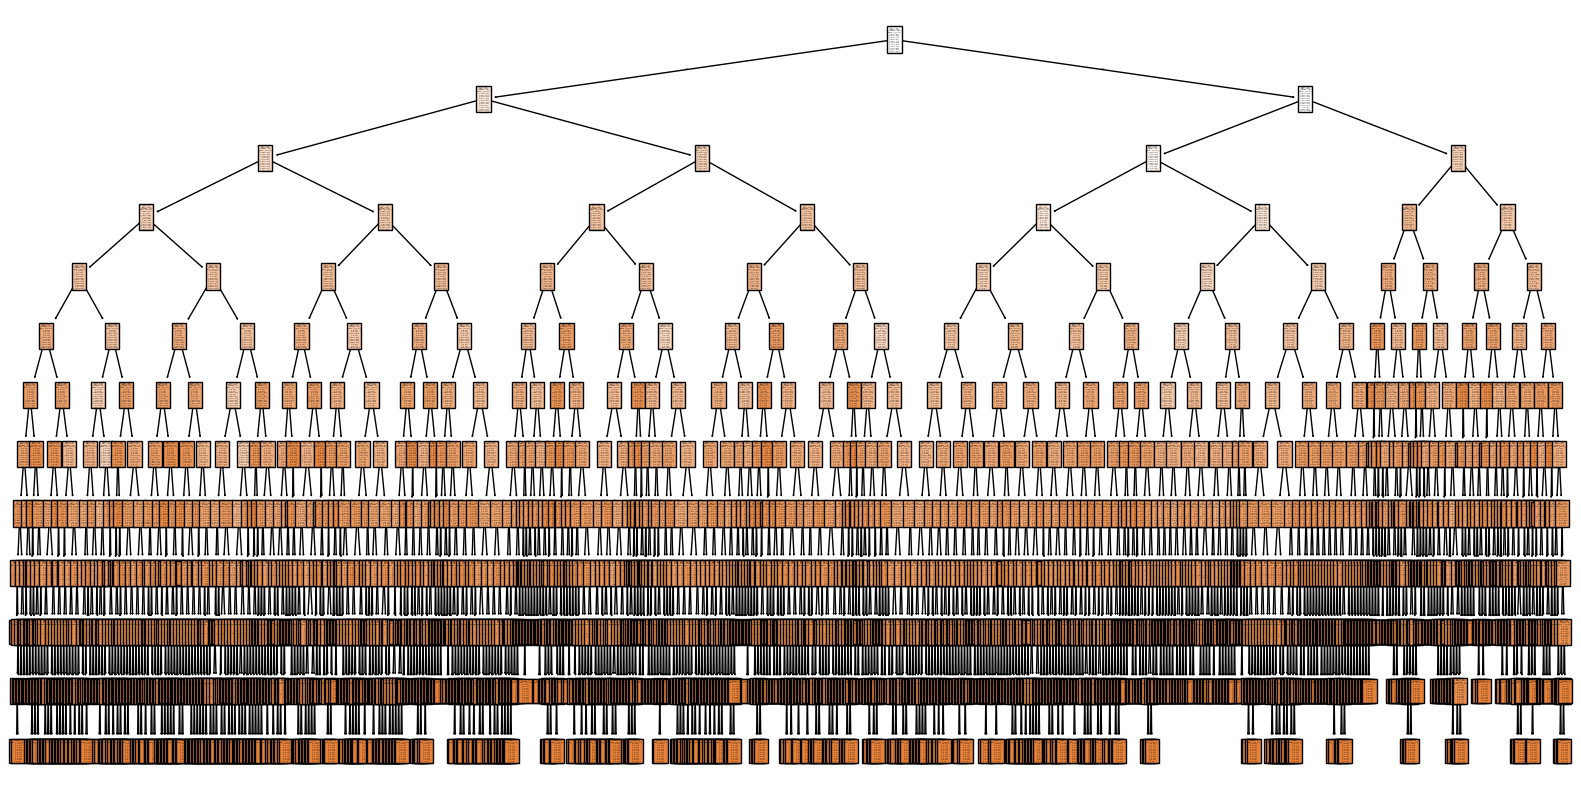

In [9]:
# display the decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model, filled=True)